In [2]:
from typing import Type, Optional, Union, Tuple

import numpy as np
import pandas as pd
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

import matplotlib.pyplot as plt 
plt.rcParams['figure.facecolor'] = "white"

from reservoir import reservoir as res
from data import data
from error import error

In [3]:
# define constants 
DEL_T = 0.01        # time step size
LAMBDA = 0.9056     # lorenz lyapunov exponent
STEPS = 30000       # total steps
WASHOUT = 20000     # washout 
n = STEPS - WASHOUT # remaining number of time steps kept
SEED = 42
state = np.random.RandomState(SEED)

In [4]:
# reservoir parameters
hyperparams = {
    'GAMMA': 7.7,
    'SIGMA': 0.81,
    'RHO_IN': 0.37,
    'K': 3,
    'RHO_R': 0.41
}

# hyperparameter ranges
GAMMA_RANGE = np.linspace(7, 11, 10)
SIGMA_RANGE = np.linspace(0.1, 1.0, 10)
RHO_IN_RANGE = np.linspace(0.3, 1.5, 10)
K_RANGE = range(1, 6)
RHO_R_RANGE = np.linspace(0.3, 1.5, 10)

# number of reservoir nodes
N = 100
# dimension of input signal
d = 3
# Tikohonov regularisation constant
ALPHA = 0.001

In [5]:
# generate some data
training_data = data.generate_lorenz_63(
    initial_state=state.choice(np.linspace(-5, 5), 3),
    del_t=DEL_T,
    steps=STEPS,
    washout=WASHOUT
)
forecast_data = data.generate_lorenz_63(
    initial_state=state.choice(np.linspace(-5, 5), 3),
    del_t=DEL_T,
    steps=STEPS,
    washout=WASHOUT
)

In [6]:
# construct reservoir internals
W_in = res.generate_W_in(hyperparams=hyperparams, shape=(N, d), seed=SEED)
W_r = res.generate_W_r(hyperparams=hyperparams, shape=(N, N), seed=SEED)

# form training reservoir
training_res = res.generate_training_reservoir(
    data=training_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    delta_t=DEL_T,
    adjust_for_symmetry=True
)

# train W_out
W_out = res.generate_W_out(
    data=training_data,
    res=training_res,
    alpha=ALPHA
)

In [7]:
# construct forecast reservoir
forecast_res = res.generate_forecast_reservoir(
    r_0 = np.dot(W_in, forecast_data[0]),
    data=forecast_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    W_out=W_out,
    delta_t=DEL_T,
    adjust_for_symmetry=True
)

# make forecasts
preds = res.readout_network(res=forecast_res, W_out=W_out)

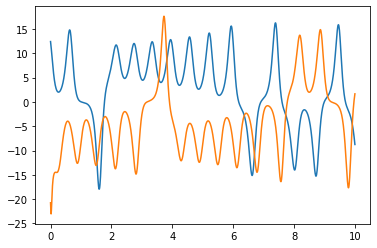

In [8]:
end = data.lyapunov_to_steps(10, LAMBDA, DEL_T)
x_range = LAMBDA * DEL_T * np.array(range(end))
plt.plot(x_range, forecast_data[:end, 0])
plt.plot(x_range, preds[:end, 0])

In [9]:
print(error.RMSE(forecast_data, preds))
print(error.griffith_epsilon_1(forecast_data, preds, DEL_T, LAMBDA))

[11.06004617 12.5381182  11.54009812]
5.352227657066499


Write a function wrapper to do a simulation.

In [10]:
def find_start_and_end(range):
    return range[0], range[-1]

def generate_search_space(gamma_range=GAMMA_RANGE, sigma_range=SIGMA_RANGE, 
                          rho_in_range=RHO_IN_RANGE, k_range=K_RANGE, 
                          rho_r_range=RHO_R_RANGE) -> list:
    gamma_start, gamma_end = find_start_and_end(gamma_range)
    sigma_start, sigma_end = find_start_and_end(sigma_range)
    rho_in_start, rho_in_end = find_start_and_end(rho_in_range)
    k_start, k_end = find_start_and_end(k_range)
    rho_r_start, rho_r_end = find_start_and_end(rho_r_range)

    return [
        hp.uniform('gamma', gamma_start, gamma_end),
        hp.uniform('sigma', sigma_start, sigma_end),
        hp.uniform('rho_in', rho_in_start, rho_in_end),
        hp.choice('k', options=list(range(k_start, k_end + 1))),
        hp.uniform('rho_r', rho_r_start, rho_r_end),
    ]

In [11]:

training_data = data.generate_lorenz_63()
forecast_data = data.generate_lorenz_63(initial_state=[2,2,2])

def objective(hyperparams: list) -> float:
    hyperparams = {
        'GAMMA': hyperparams[0],
        'SIGMA': hyperparams[1],
        'RHO_IN': hyperparams[2],
        'K': hyperparams[3],
        'RHO_R': hyperparams[4]
    }
    
    W_r = res.generate_W_r(hyperparams, (N, N), 42)
    W_in = res.generate_W_in(hyperparams, (N, d), 42)
    
    training_res = res.generate_training_reservoir(
        data = training_data,
        hyperparams = hyperparams,
        W_r = W_r,
        W_in = W_in,
        delta_t = DEL_T
    )
    
    W_out = res.generate_W_out(data=training_data, res=training_res, alpha=ALPHA)
    forecast_res = res.generate_forecast_reservoir(
        r_0 = np.dot(W_in, forecast_data[0]),
        data = forecast_data,
        hyperparams=hyperparams,
        W_r = W_r,
        W_in = W_in,
        W_out = W_out,
        delta_t = DEL_T
    )

    preds = res.readout_network(res=forecast_res, W_out=W_out)

    return max(error.RMSE(forecast_data, preds))

best = fmin(
    fn=objective,
    space=generate_search_space(),
    algo=tpe.suggest,
    max_evals=100
)
print(best)

100%|██████████| 100/100 [00:18<00:00,  5.34trial/s, best loss: 12.764370382715288]
{'gamma': 8.639873343447757, 'k': 2, 'rho_in': 0.302767714652039, 'rho_r': 0.6132864899591787, 'sigma': 0.2901006079608579}


In [34]:
# define constants 
DEL_T = 0.01        # time step size
LAMBDA = 0.9056     # lorenz lyapunov exponent
STEPS = 30000       # total steps
WASHOUT = 20000     # washout 
n = STEPS - WASHOUT # remaining number of time steps kept
N = 100
d = 3
ALPHA = 0.001

GAMMA_RANGE = np.linspace(7, 11)
SIGMA_RANGE = np.linspace(0.1, 1.0)
RHO_IN_RANGE = np.linspace(0.2, 1)
K_RANGE = range(1, 6)
RHO_R_RANGE = np.linspace(0.3, 1.5)

def run_sim(search_space: list, seed: int, N: int = N, d: int = d, 
            alpha: float = ALPHA, show_progressbar: bool = True, 
            adjust_for_symmetry: bool = True) -> Tuple[dict, Trials]:
    # set state
    state = np.random.RandomState(SEED)

    # generate some data
    training_data = data.generate_lorenz_63(
        initial_state=state.choice(np.linspace(-5, 5), 3),
        del_t=DEL_T,
        steps=STEPS,
        washout=WASHOUT
    )
    forecast_data = data.generate_lorenz_63(
        initial_state=state.choice(np.linspace(-5, 5), 3),
        del_t=DEL_T,
        steps=STEPS,
        washout=WASHOUT
    )
    # uses 'constants' that are passed in
    def objective(hyperparams: list) -> float:
        # parse hyperparams list
        hyperparams = {
            'GAMMA': hyperparams[0],
            'SIGMA': hyperparams[1],
            'RHO_IN': hyperparams[2],
            'K': hyperparams[3],
            'RHO_R': hyperparams[4]
        }

        # construct reservoir internals
        W_in = res.generate_W_in(hyperparams=hyperparams, shape=(N, d), seed=seed)
        W_r = res.generate_W_r(hyperparams=hyperparams, shape=(N, N), seed=seed)

        # form training reservoir
        training_res = res.generate_training_reservoir(
            data=training_data,
            hyperparams=hyperparams,
            W_r=W_r,
            W_in=W_in,
            delta_t=DEL_T,
            adjust_for_symmetry=adjust_for_symmetry
        )

        # train W_out
        W_out = res.generate_W_out(
            data=training_data,
            res=training_res,
            alpha=alpha
        )

        # construct forecast reservoir
        forecast_res = res.generate_forecast_reservoir(
            r_0 = np.dot(W_in, forecast_data[0]),
            data=forecast_data,
            hyperparams=hyperparams,
            W_r=W_r,
            W_in=W_in,
            W_out=W_out,
            delta_t=DEL_T,
            adjust_for_symmetry=adjust_for_symmetry
        )

        # make forecasts
        preds = res.readout_network(res=forecast_res, W_out=W_out)

        # compute loss
        return {
            'loss': np.linalg.norm(error.RMSE(forecast_data, preds)),
            'status': STATUS_OK,
            'W_r': {'type': np.ndarray, 'value': W_r},
            'W_in': {'type': np.ndarray, 'value': W_in},
            'W_out': {'type': np.ndarray, 'value': W_out},
            'training_res': {'type': np.ndarray, 'value': training_res},
            'forecast_res': {'type': np.ndarray, 'value': forecast_res},
            'preds': {'type': np.ndarray, 'value': preds},
        }

    trials = Trials()
    best = fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=100,
        show_progressbar=show_progressbar,
        trials=trials
    )

    return best, trials, training_data, forecast_data

In [35]:
search_space = generate_search_space()
best, trials, training_data, forecast_data = run_sim(
    search_space=search_space,
    seed=SEED
)

100%|██████████| 100/100 [03:07<00:00,  1.88s/trial, best loss: 19.98673179832154]


In [36]:
print(best)

{'gamma': 8.474096203622938, 'k': 1, 'rho_in': 0.5388299857343897, 'rho_r': 1.4261640858285394, 'sigma': 0.14481360343969138}


In [37]:
def plot_param_vs_loss(trials, param):
    trial_params = [trials.trials[i]['misc']['vals'] for i in range(len(trials.losses()))]
    losses = trials.losses()

    params = [trial_params[i][param][0] for i in range(len(trials.losses()))]

    plt.title("Loss as a function of {}".format(param))
    plt.scatter(params, losses)
    plt.xlabel("{}".format(param))
    plt.ylabel("Loss")

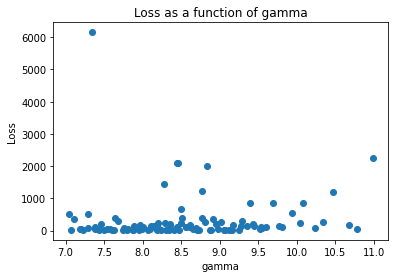

In [38]:
plot_param_vs_loss(trials, "gamma")

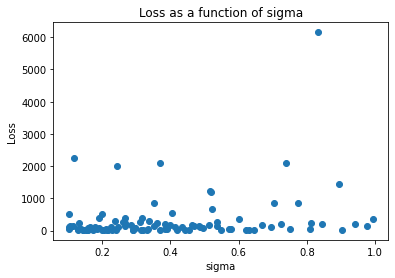

In [39]:
plot_param_vs_loss(trials, "sigma")

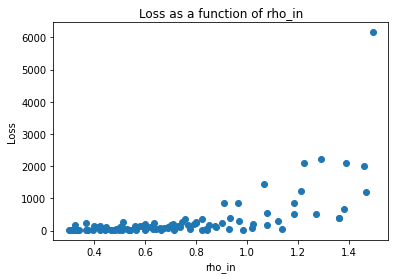

In [40]:
plot_param_vs_loss(trials, "rho_in")

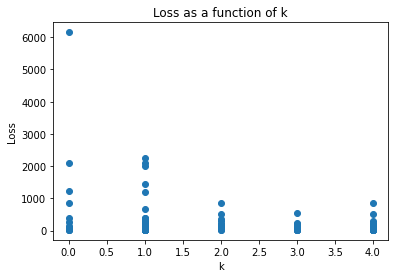

In [41]:
plot_param_vs_loss(trials, "k")

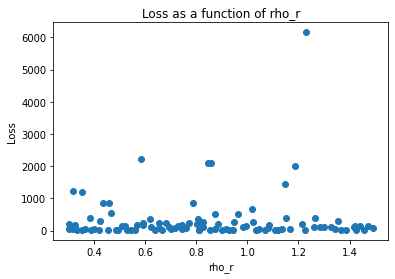

In [42]:
plot_param_vs_loss(trials, "rho_r")

In [43]:
results = pd.DataFrame(trials.trials)
results.head()

,state,tid,spec,result,misc,exp_key,owner,version,book_time,refresh_time
0,2,0,None,"{'loss': 1223.4098277859084, 'status': 'ok', '...","{'tid': 0, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2022-07-13 13:46:56.028,2022-07-13 13:46:57.586
1,2,1,None,"{'loss': 53.95714597587044, 'status': 'ok', 'W...","{'tid': 1, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2022-07-13 13:46:57.587,2022-07-13 13:46:59.239
2,2,2,None,"{'loss': 50.11654403280265, 'status': 'ok', 'W...","{'tid': 2, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2022-07-13 13:46:59.241,2022-07-13 13:47:00.854
3,2,3,None,"{'loss': 2085.9130304402247, 'status': 'ok', '...","{'tid': 3, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2022-07-13 13:47:00.855,2022-07-13 13:47:02.501
4,2,4,None,"{'loss': 6156.307479643845, 'status': 'ok', 'W...","{'tid': 4, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2022-07-13 13:47:02.503,2022-07-13 13:47:04.074


In [44]:
results['loss'] = [results['result'].iloc[i]['loss'] for i in range(results.shape[0])]

In [45]:
index_of_best = results['loss'].idxmin()

In [46]:
best_results = results.iloc[index_of_best]['result']

In [47]:
best_preds = best_results['preds']['value']

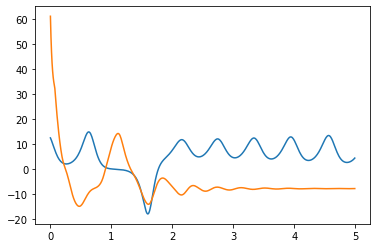

In [48]:
end = data.lyapunov_to_steps(5, LAMBDA, DEL_T)
x_range = LAMBDA * DEL_T * np.array(range(end))
fig = plt.figure()
plt.plot(x_range, forecast_data[:end, 0])
plt.plot(x_range, best_preds[:end, 0])

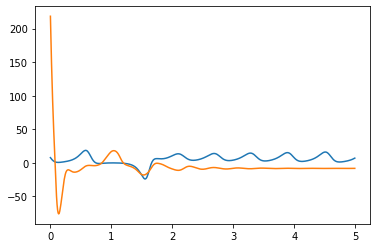

In [49]:
end = data.lyapunov_to_steps(5, LAMBDA, DEL_T)
x_range = LAMBDA * DEL_T * np.array(range(end))
fig = plt.figure()
plt.plot(x_range, forecast_data[:end, 1])
plt.plot(x_range, best_preds[:end, 1])

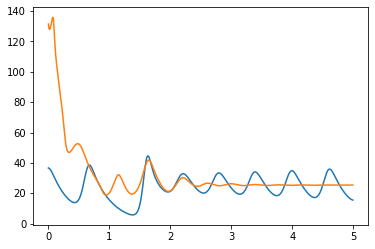

In [50]:
end = data.lyapunov_to_steps(5, LAMBDA, DEL_T)
x_range = LAMBDA * DEL_T * np.array(range(end))
fig = plt.figure()
plt.plot(x_range, forecast_data[:end, 2])
plt.plot(x_range, best_preds[:end, 2])